In [217]:
#installing dependencies
import sqlite3
import pandas as pd  

dbfile = '/Users/sofyakonchakova/Desktop/Data_Science/data/home-assistant_v2.db'


### SQL Data Pulling

I removed the code for other databases as we will stick to this one.

In [218]:
#acessing the states database
with sqlite3.connect(dbfile) as con:
    cur = con.cursor()
    cur.execute("SELECT * FROM states")
    states = cur.fetchall()

    
#converting it to the pandas data frame
from_states_db = []

for result in states:
    result = list(result)
    from_states_db.append(result)

columns = ["state_id","domain","entity_id","state","attributes","event_id","last_changed","last_updated","created","old_state_id"]
states_df = pd.DataFrame(from_states_db, columns = columns)

In [219]:
states_df.head()

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,old_state_id
0,11244860,zwave,zwave.switch_cr,ready,"{""node_id"":15,""node_name"":""Shenzhen Neo Electr...",11287622,2021-11-28 20:46:35.720593,2021-12-02 03:12:05.162304,2021-12-02 03:12:05.162304,NaN
1,11244861,sensor,sensor.switch_cr_exporting,False,"{""node_id"":15,""value_index"":32,""value_instance...",11287623,2021-12-02 03:12:05.162807,2021-12-02 03:12:05.162807,2021-12-02 03:12:05.162807,NaN
2,11244862,sensor,sensor.switch_cr_energy,6.86,"{""node_id"":15,""value_index"":0,""value_instance""...",11287624,2021-12-02 03:12:05.191776,2021-12-02 03:12:05.191776,2021-12-02 03:12:05.191776,NaN
3,11244863,sensor,sensor.switch_cr_previous_reading_1,6.86,"{""node_id"":15,""value_index"":1,""value_instance""...",11287625,2021-12-02 03:12:05.220377,2021-12-02 03:12:05.220377,2021-12-02 03:12:05.220377,NaN
4,11244864,sensor,sensor.switch_cr_interval_1,301,"{""node_id"":15,""value_index"":2,""value_instance""...",11287626,2021-12-02 03:12:05.252402,2021-12-02 03:12:05.252402,2021-12-02 03:12:05.252402,NaN


### Preparation Agent
We received data frame that has dictionaries in column value. In this section, we bring the data frame to the wide format, additionally unpacking the column.

In [220]:
df = states_df.copy()

In [221]:

df['attributes'] = df['attributes'].apply(lambda x: x.replace('true','True'))
df['attributes'] = df['attributes'].apply(lambda x: x.replace('false','False'))
df['attributes'] = df['attributes'].apply(lambda x: x.replace('null','None'))


df['attributes']=df['attributes'].apply(lambda dat: dict(eval(dat)))
df2 = pd.json_normalize(df['attributes'])
result = pd.concat([df,df2], axis = 1).drop('attributes', axis = 1)

In [222]:
trial = result.copy()
trial = trial.dropna(thresh=10000,axis = 1)

In [223]:
trial

,state_id,domain,entity_id,state,event_id,last_changed,last_updated,created,old_state_id,node_id,...,value_instance,value_id,power_consumption,unit_of_measurement,neighbors,battery_level,wake_up_interval,device_class,icon,attribution
0,11244860,zwave,zwave.switch_cr,ready,11287622,2021-11-28 20:46:35.720593,2021-12-02 03:12:05.162304,2021-12-02 03:12:05.162304,NaN,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11244861,sensor,sensor.switch_cr_exporting,False,11287623,2021-12-02 03:12:05.162807,2021-12-02 03:12:05.162807,2021-12-02 03:12:05.162807,NaN,15.0,...,1.0,72057594294600192,0.0,,NaN,NaN,NaN,NaN,NaN,NaN
2,11244862,sensor,sensor.switch_cr_energy,6.86,11287624,2021-12-02 03:12:05.191776,2021-12-02 03:12:05.191776,2021-12-02 03:12:05.191776,NaN,15.0,...,1.0,72057594294599682,0.0,kWh,NaN,NaN,NaN,NaN,NaN,NaN
3,11244863,sensor,sensor.switch_cr_previous_reading_1,6.86,11287625,2021-12-02 03:12:05.220377,2021-12-02 03:12:05.220377,2021-12-02 03:12:05.220377,NaN,15.0,...,1.0,72057594294599698,0.0,kWh,NaN,NaN,NaN,NaN,NaN,NaN
4,11244864,sensor,sensor.switch_cr_interval_1,301,11287626,2021-12-02 03:12:05.252402,2021-12-02 03:12:05.252402,2021-12-02 03:12:05.252402,NaN,15.0,...,1.0,72057594294599715,0.0,seconds,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507500,11752360,sensor,sensor.thermostat_br_system,254,11796251,2021-12-12 09:28:16.840038,2021-12-12 09:28:16.840038,2021-12-12 09:28:16.840038,11752215.0,5.0,...,1.0,72057594127859905,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
507501,11752361,zwave,zwave.thermostat_br,ready,11796247,2021-12-11 22:37:51.431086,2021-12-12 09:28:16.759145,2021-12-12 09:28:16.759145,11752355.0,5.0,...,NaN,NaN,NaN,NaN,"[34, 45, 47, 48, 18, 22, 23, 24, 25, 26]",30.0,NaN,NaN,NaN,NaN
507502,11752362,sensor,sensor.thermostat_br_alarm_type,0,11796248,2021-12-12 09:28:16.759919,2021-12-12 09:28:16.759919,2021-12-12 09:28:16.759919,11752356.0,5.0,...,1.0,72057594127859713,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
507503,11752363,sensor,sensor.thermostat_br_alarm_level,0,11796249,2021-12-12 09:28:16.790736,2021-12-12 09:28:16.790736,2021-12-12 09:28:16.790736,11752357.0,5.0,...,1.0,72057594127859729,NaN,,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
#here i specify which node i use. how the user specifies it?
kwh_data = trial[trial.unit_of_measurement.isin(['kWh']) & trial.node_id.isin([3,15,34,46])]

kwh_data_long = kwh_data[['node_id','last_changed', 'power_consumption','entity_id']]
kwh_data_wide = pd.pivot(kwh_data_long, index = ['last_changed', 'entity_id'], columns = 'node_id', values = 'power_consumption')

In [225]:
#filling nas with zeros 
kwd_data_wide = kwh_data_wide.fillna(0)
df = kwd_data_wide.reset_index()
REFIT_df = df.reset_index().copy()

In [226]:
#aggregating per hour
df.last_changed = pd.to_datetime(df.last_changed)
df = df.resample('60T', on="last_changed").sum()


In [227]:
#three nodes out of use?
df.sum()

node_id
3.0     4923.51
15.0       0.00
34.0       0.00
46.0    2510.22
dtype: float64

In [240]:
class Preparation_Agent:
    def __init__(self):
        self.input = df

prep = Preparation_Agent()



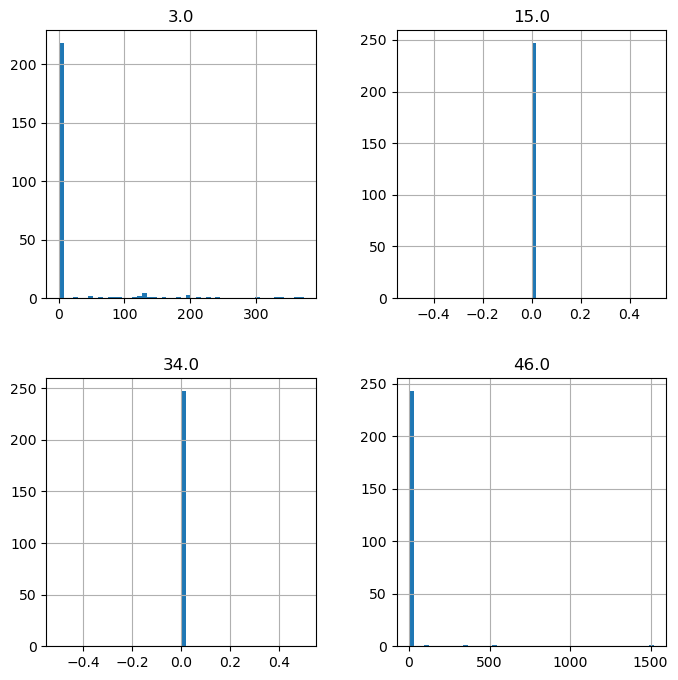

In [243]:
# Histogram
prep.input.hist(bins=50, figsize=(8,8));

In [244]:
def outlier_truncation(self, series, factor=1.5, verbose=0):
    from tqdm import tqdm
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    
    lower_bound = q1 - factor*iqr
    upper_bound = q3 + factor*iqr
    
    output = []
    counter = 0
    for item in (tqdm(series, desc=f'[outlier truncation: {series.name}]') if verbose != 0 else series):
        if item > upper_bound:
            output.append(int(upper_bound))
            counter += 1
        elif item < lower_bound:
            output.append(int(lower_bound))
            counter += 1
        else:
            output.append(item)
    print(f'[outlier truncation: {series.name}]: {counter} outliers were truncated.') if verbose != 0 else None 
    return output

# add the function to the class and delete global function
setattr(Preparation_Agent, 'outlier_truncation', outlier_truncation)
del outlier_truncation

In [204]:
REFIT_df.loc[:,3]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
27342    0.0
27343    0.0
27344    0.0
27345    0.0
27346    0.0
Name: 3.0, Length: 27347, dtype: float64

In [207]:
REFIT_df.rename()

node_id,index,last_changed,entity_id,3.0,15.0,34.0,46.0
0,0,2021-12-02 03:12:05.191776,sensor.switch_cr_energy,0.0,0.0,0.0,0.0
1,1,2021-12-02 03:12:05.220377,sensor.switch_cr_previous_reading_1,0.0,0.0,0.0,0.0
2,2,2021-12-02 03:14:28.759061,sensor.switch_energy_f1,0.0,0.0,0.0,0.0
3,3,2021-12-02 03:14:28.784946,sensor.switch_previous_reading_f1,0.0,0.0,0.0,0.0
4,4,2021-12-02 03:14:29.044008,sensor.switch_energy_f1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
27342,27342,2021-12-12 09:25:12.058839,sensor.switch_k_previous_reading_1,0.0,0.0,0.0,0.0
27343,27343,2021-12-12 09:25:12.570707,sensor.switch_k_energy,0.0,0.0,0.0,0.0
27344,27344,2021-12-12 09:25:12.610626,sensor.switch_k_previous_reading_1,0.0,0.0,0.0,0.0
27345,27345,2021-12-12 09:27:27.509591,sensor.switch_energy_br,0.0,0.0,0.0,0.0


In [247]:
def pipeline_extracting(self, df, params):
    import sqlite3
    import pandas as pd 
    
     

3 - kitchen lamp 
15 - child room lamp
34 - bedroom lamp
46 - living room
41 - 
48 - rolls for windows, disregard


-> aggregate per hour


-> focus on integration